In [1]:
import matplotlib.pyplot as plt
import rHeston
import numpy as np

import Heston
import BlackScholes as bs
import ImpliedDrift

import QuantLib as ql
import pandas as pd
import copy

import datetime
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.optimize import least_squares

import time

In [2]:
# Read the dataset

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()


spot = 4019.81
strikes = moneyness*spot/100
data = np.array(IV_df.drop(columns = 'Exp Date'))/100.

# Calculate the expiration dates and the Implied Drift


risk_free_rate = list()
q = list()

for j in range(len(maturities)):
    risk_free_rate.append(float(ImpliedDrift.r(maturities[j])))
    q.append(float(ImpliedDrift.q(maturities[j])))
    
# Add the last point at 100 years for the Implied Drift

N_tenors = len(maturities)
N_strikes = len(strikes)

theta = 0.4
H = 0.01
rho = -0.65

prms = (theta, H, rho)

options_type = np.ones(N_strikes)

In [3]:
# Objective function 

def f(prms):
    theta, H, rho = prms
    IV = np.zeros((N_tenors,N_strikes))   
    
    for i in range(N_tenors):
        IV[i,:] = rHeston.analytic_rhest(spot, strikes, maturities[i], H, rho, theta, options_type)
        IV[i,:] = bs.BSImpliedVol(spot, strikes, maturities[i], risk_free_rate[i], q[i], IV[i,:],
                                Option_type = 1, toll = 1e-5)
    return (IV - data).flatten()

In [4]:
%%time

res_wrapped = least_squares(f, prms, bounds=([1e-2,1e-3,-1.],[3., 0.4, 1.]))
theta, H, rho = res_wrapped.x
print(f"theta = {theta: .4f}, H = {H: .4f}, rho = {rho: .4f}")

theta =  0.2817, H =  0.0010, rho = -0.6995
CPU times: total: 2min 49s
Wall time: 2min 49s


In [5]:
# Calculate the prices with the calibrated model and the corresponding IV

IV = np.zeros((N_tenors,N_strikes))    
for i in range(N_tenors):
    IV[i,:] = rHeston.analytic_rhest(spot, strikes, maturities[i], H, rho, theta, options_type)
    IV[i,:] = bs.BSImpliedVol(spot, strikes, maturities[i], risk_free_rate[i], q[i], IV[i,:],
                                 Option_type = 1, toll = 1e-5)
    
print(f"Mean relative error on IV: {np.mean(abs(data-IV)/data)*100:.4f}%")

Mean relative error on IV: 6.4480%


<IPython.core.display.Javascript object>


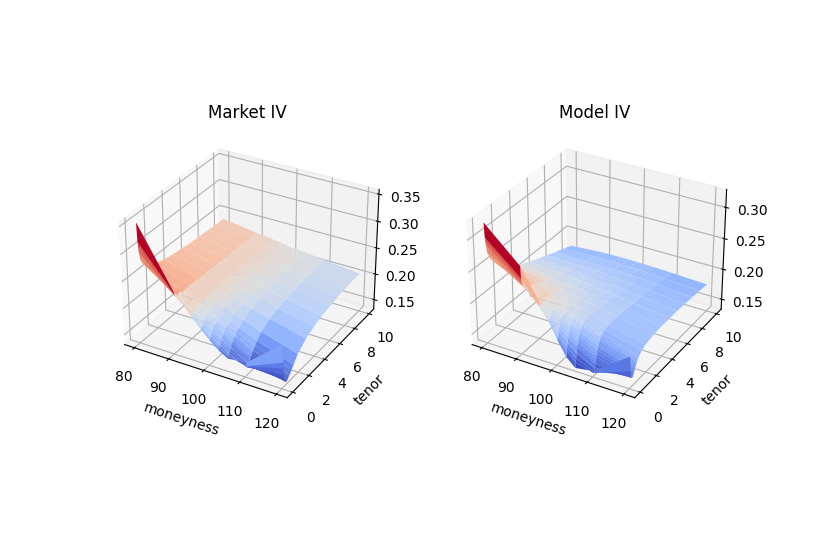

In [7]:
%matplotlib notebook

mesh_x, mesh_y = np.meshgrid(moneyness,maturities[1:])

fig = plt.figure()
ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, data[1:,:], cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('moneyness')
ax1.set_ylabel('tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, IV[1:,:], cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('moneyness')
ax2.set_ylabel('tenor')
ax2.set_title('Model IV')

plt.show()